# An Introduction to Dark Energy Survey Data Wrangling

This notebook contains an introduct to the various concepts and tools that are useful for using and understanding data from the Dark Energy Survey (DES). 

Some assumptions and prerequisites:

1. I am assuming that you have access to data downloaded from DES Data Management (DESDM) in the form of coadd tile data and inputs used for building "pizza slice" coadd MEDS files. However, even if you don't have the data in this form locally, you can still use the information in this tutorial.

2. The data formats here are specific to the Year 6 DES data reductions. Previous years are similar, but not identical.

3. You will need the following python packages installed locally: `fitsio`, `pyyaml`, `esutil`, `matplotlib`, and `numpy`. Your best bet is to use `conda` to install them via `conda install fitsio pyyaml esutil matplotlib numpy`.

In [1]:
import os
import fitsio
import yaml
import esutil
import numpy as np

import matplotlib.pyplot as plt

## Getting Started

Before we dig into the images and associated metadata, we need to know where it is. For this purpose, I have created special YAML files that have all of the paths and other information you need in them. 

You can find them on `phoenix` here:

```
/cosmo/scratch/mrbecker/MEDS_DIR/des-pizza-slices-y6-v8/pizza_cutter_info
```

Each file has a name that looks like 

```
<coadd tilename>_<band>_pizza_cutter_info.yaml
```

In the DES, the coadd tilenames are things like `DES0124-3332` and the band is a single character (e.g., one of `g`, `r`, `i`, `z`, etc.). So for example, you'd find the file:

```
/cosmo/scratch/mrbecker/MEDS_DIR/des-pizza-slices-y6-v8/pizza_cutter_info/DES0124-3332_i_pizza_cutter_info.yaml
```

For band `i` and coadd tile `DES0124-3332`.

Loading them into python is straight forward like this:

In [2]:
meds_dir = "/cosmo/scratch/mrbecker/MEDS_DIR"
tilename = "DES0124-3332"
band = "i"
yaml_pth = os.path.join(
    meds_dir, 
    "des-pizza-slices-y6-v8/pizza_cutter_info/%s_%s_pizza_cutter_info.yaml" % (
        tilename, band
    )
)

with open(yaml_pth, "r") as fp:
    info = yaml.safe_load(fp.read())

This dictionary has two major parts. First, it has a set of top-level keys that hold data for the coadd image. Second, it has a `src_info` key which holds a list of dictionaries. The dicts in this list hold information for the single epoch images that get combined into the coadd. Let's take a quick look:

In [3]:
print("coadd info:")
for k, v in info.items():
    if k == "src_info":
        continue
    print("    %s: %s" % (
        k,
        v.replace(meds_dir, "$MEDS_DIR") if isinstance(v, str) else v,
    ))

coadd info:
    band: i
    bmask_ext: msk
    bmask_path: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/multiepoch/Y6A1/r4907/DES0124-3332/p01/coadd/DES0124-3332_r4907p01_i.fits.fz
    cat_path: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/multiepoch/Y6A1/r4907/DES0124-3332/p01/cat/DES0124-3332_r4907p01_i_cat.fits
    compression: .fz
    crossra0: N
    filename: DES0124-3332_r4907p01_i.fits
    gaia_stars_file: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/cal/cat_tile_gaia/v1/DES0124-3332_GAIA_DR2_v1.fits
    image_ext: sci
    image_flags: 0
    image_path: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/multiepoch/Y6A1/r4907/DES0124-3332/p01/coadd/DES0124-3332_r4907p01_i.fits.fz
    image_shape: [10000, 10000]
    magzp: 30.0
    path: OPS/multiepoch/Y6A1/r4907/DES0124-3332/p01/coadd
    pfw_attempt_id: 2828855
    position_offset: 1
    psf_path: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/multiepoch/Y6A1/r49

Here is what is in there for a single image:

In [4]:
print("single-epoch image 0:")
for k, v in info["src_info"][0].items():
    if k == "src_info":
        continue
    print("    %s: %s" % (
        k,
        v.replace(meds_dir, "$MEDS_DIR") if isinstance(v, str) else v,
    ))

single-epoch image 0:
    band: i
    bkg_ext: sci
    bkg_path: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/finalcut/Y5A1/r3630/20161219/D00602600/p01/red/bkg/D00602600_i_c04_r3630p01_bkg.fits.fz
    bmask_ext: msk
    bmask_path: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/finalcut/Y5A1/r3630/20161219/D00602600/p01/red/immask/D00602600_i_c04_r3630p01_immasked.fits.fz
    ccdnum: 4
    compression: .fz
    expnum: 602600
    filename: D00602600_i_c04_r3630p01_immasked.fits
    head_path: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/multiepoch/Y6A1/r4907/DES0124-3332/p01/aux/DES0124-3332_r4907p01_D00602600_i_c04_scamp.ohead
    image_ext: sci
    image_flags: 0
    image_path: $MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/finalcut/Y5A1/r3630/20161219/D00602600/p01/red/immask/D00602600_i_c04_r3630p01_immasked.fits.fz
    image_shape: [4096, 2048]
    magzp: 31.62564468383789
    path: OPS/finalcut/Y5A1/r3630/20161219/D00602600

The meaning of many of these keys won't be clear until we walk about the data itself a bit more, which we do next.

## What is in DES data anyways?

DES data has several main parts/ideas, some of which I have already hinted at. They are

 - **exposure**: A single opening and closing of the shutter of the telescope. All CCDs on the telescope take
   an image during a single exposure.
 - **ccd number**: A numerical identifier for each DECam CCD.
 - **band**: The passband filter used for a givne exposure. These filters allow us to only measure certain colors 
   of light in a single exposure.
 - **single-epoch images**: The output image from a single DECam CCD for a single exposure and band. 
   Every single-epoch image is tagged with exposure and CCD number.
 - **final-cut image**: A single-epoch image that has been fully calibrated and processed by the DES pipelines. 
   You will almost always be using a final-cut image. These are used as inputs to the image coadding process.
 - **coadd images**: These are images computed by taking a weighted average of all of the final-cut images that 
   intersect a given region of the sky. 
 - **coadd tile**: In the DES, a coadd image is formed for every coadd tile. The coadd tile sets the location of the 
   10kx10k coadd image. As implied by the name, the coadd tiles "tile" the entire sky so that every positions falls in 
   a coadd tile. Coadd tiles have overlaps on the edges. These need to be cut away at the end of the coadding process.
 - **world coordinate system**: The world coordinate system or WCS is a coordinate transform that maps each possible 
   position in an image to a point on the sphere. This mapping is unique (one-to-one and onto) in the domain covered 
   by the image.
 - **bit mask**: The bit mask or "bmask" is an image of integers corresponding to every pixel in the final-cut image.
   The different bits in these integers indicate different potential problems or things that happened to that pixel. 
   Usually, but not always, you want `bmask == 0` to indicate pixels which are clean.
 - **weight map**: The weight map is an image of non-negative values corresponding to every pixel in the final-cut 
   image. These values are the inverse of the variance in each pixel value `v`, `1/Var[v]`. A weight of 0 indicates a 
   pixel with infinite variance (so unusable data). Conversely, a large weight indicates a low variance pixel.
 - **background image**: This image, only present for final-cut images, contains the background level in the image and 
   should be subtracted from the final-cut image before using it.
 - **segmentation map**: The segementation map or "seg map" is an image of integers, one for each pixel, produced 
   by the software that finds objects in the images. A value of 0 indicates a "sky" pixel (no detected objects). A 
   value of 1 or greater, indicates a pixel that "belongs" to a given object as indicated by the pixel value. Even 
   though objects can overlap, each pixel is assigned to one and only one object. 
 - **zero point**: Every final-cut image has an estimated zero-point. This quantity is a single scalar value that can 
   be used to adjust the amplitude of the image so that every image is in the same units. For the coadd, this zero-
   point is defined by hand so that no adjustment is needed. We'll cover how to make the adjustment below.

## Reading the Coadd Data

Images in the DES are stored in a format called FITS. The details of this format are unimportant. The key facts you need are that 

1. A FITS file can hold more than one image. 
2. In the DES, each image is in a named extension.
3. A FITS file also has a field for header values. Header values are key-value pairs and generally hold metadata for 
   the image.
   
We use a package called `fitsio` to read the images and the headers like this:

In [5]:
im = fitsio.read(info["image_path"], ext=info["image_ext"])

The image `im` is the coadd image for this tile:

In [6]:
im.shape

(10000, 10000)

You can see that it is 10k x 10k pixels. Let's make a plot.

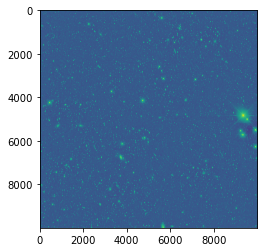

In [7]:
fig, axs = plt.subplots()
axs.imshow(np.arcsinh(im))

The general pattern for reading the rest of the images is the same.

In [8]:
im = fitsio.read(info["image_path"], ext=info["image_ext"])
seg = fitsio.read(info["seg_path"], ext=info["seg_ext"])
wgt = fitsio.read(info["weight_path"], ext=info["weight_ext"])
bmask = fitsio.read(info["bmask_path"], ext=info["bmask_ext"])

Note the correspondence between the name of the key in the dictionary and the data product name (e.g., the seg map is called `seg_*`, the bit mask is called `bmask_*` etc.). Here is what they look like:

Text(0.5, 1.0, 'bit mask')

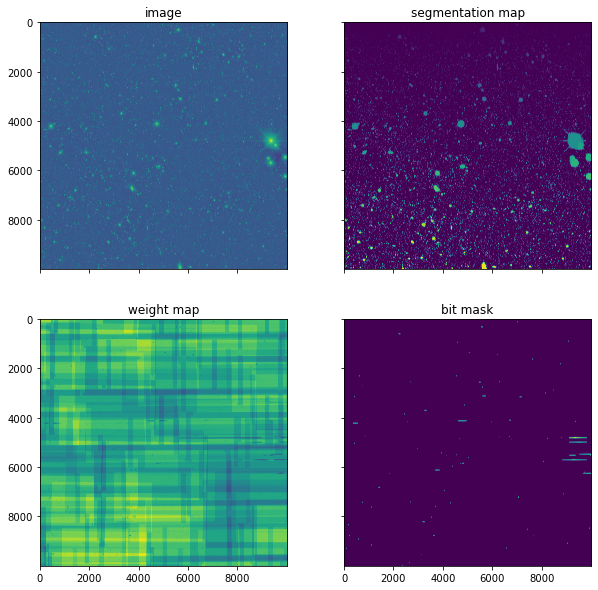

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='all', sharey='all', figsize=(10, 10))
axs[0, 0].imshow(np.arcsinh(im))
axs[0, 0].set_title("image")
axs[0, 1].imshow(seg)
axs[0, 1].set_title("segmentation map")
axs[1, 0].imshow(np.arcsinh(wgt))
axs[1, 0].set_title("weight map")
axs[1, 1].imshow(bmask)
axs[1, 1].set_title("bit mask")

## Reading the Single-epoch/Final-cut Data

Remember above we said that a coadd image formed from a sum of final-cut images. Each of these final-cut images is an image from a single CCD. 

The information for these images is stored in the `src_info` key. This key is a list of dictionaries, each dictionary with similar keys giving the information on the different image products.

So for our curren tile, we can get the number of single-epoch images that feed into via:

In [10]:
len(info['src_info'])

161

To examine the first image, you grab the entry in this list at the proper index value. Note the index value is one less than the place of the image in the list.

In [11]:
print(info['src_info'][0])

{'band': 'i', 'bkg_ext': 'sci', 'bkg_path': '/cosmo/scratch/mrbecker/MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/finalcut/Y5A1/r3630/20161219/D00602600/p01/red/bkg/D00602600_i_c04_r3630p01_bkg.fits.fz', 'bmask_ext': 'msk', 'bmask_path': '/cosmo/scratch/mrbecker/MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/finalcut/Y5A1/r3630/20161219/D00602600/p01/red/immask/D00602600_i_c04_r3630p01_immasked.fits.fz', 'ccdnum': 4, 'compression': '.fz', 'expnum': 602600, 'filename': 'D00602600_i_c04_r3630p01_immasked.fits', 'head_path': '/cosmo/scratch/mrbecker/MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/multiepoch/Y6A1/r4907/DES0124-3332/p01/aux/DES0124-3332_r4907p01_D00602600_i_c04_scamp.ohead', 'image_ext': 'sci', 'image_flags': 0, 'image_path': '/cosmo/scratch/mrbecker/MEDS_DIR/des-pizza-slices-y6-v8/DES0124-3332/sources-i/OPS/finalcut/Y5A1/r3630/20161219/D00602600/p01/red/immask/D00602600_i_c04_r3630p01_immasked.fits.fz', 'image_shape': [4096, 2048], 'mag

We can get the exposure number, ccd number and other useful information like this:

In [12]:
si = info['src_info'][0]
print("exposure:", si['expnum'])
print("ccd:", si['ccdnum'])
print("band:", si['band'])

exposure: 602600
ccd: 4
band: i


When reading and use the final-cut images, we have to make a series of transformations before they are ready. 

1. We need to subtract the background image.
2. We need to apply the zero-point, which involves multiplying by the `scale` entry. This has to happen for both the 
   image and the weight map. For the weight map, we divide by `scale**2` since it is `1/variance` and so has units of 
   `1/image**2`.

Here is an example.

In [13]:
# first we read in the data
raw_se_im = fitsio.read(si["image_path"], ext=si["image_ext"])
bkg_im = fitsio.read(si["bkg_path"], ext=si["bkg_ext"])
raw_se_wgt = fitsio.read(si["weight_path"], ext=si["weight_ext"])
se_bmask = fitsio.read(si["bmask_path"], ext=si["bmask_ext"])

# now subtract the background
se_im = raw_se_im - bkg_im

# and apply the scale
scale = si['scale']
se_im = se_im * scale
se_wgt = raw_se_wgt / scale**2

Finally, let's plot the data.

Text(0.5, 1.0, 'bit mask')

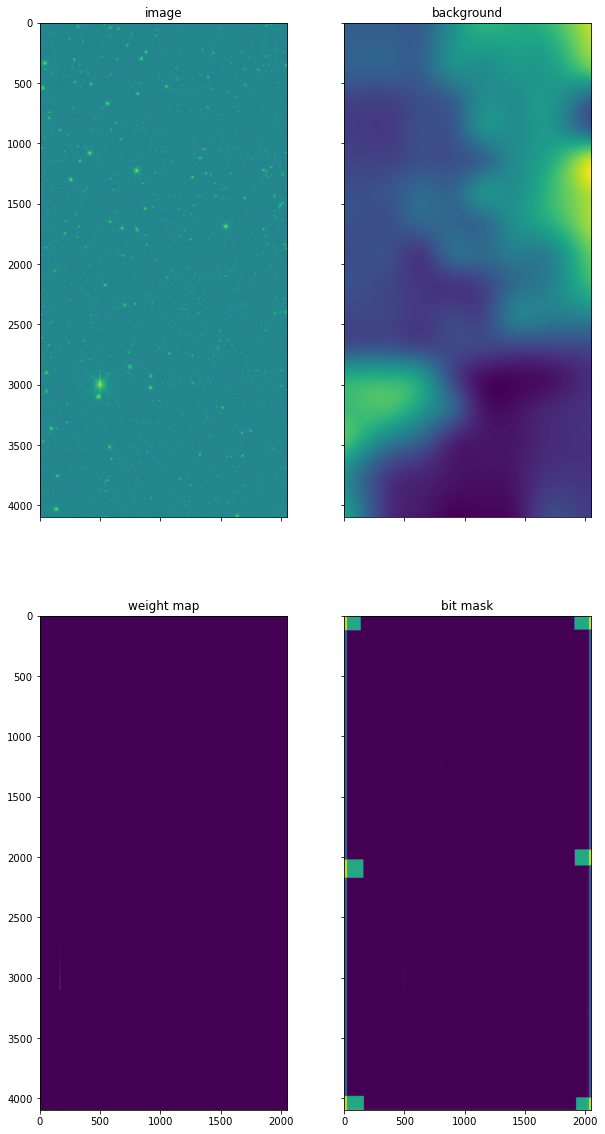

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='all', sharey='all', figsize=(10, 20))
axs[0, 0].imshow(np.arcsinh(se_im))
axs[0, 0].set_title("image")
axs[0, 1].imshow(bkg_im)
axs[0, 1].set_title("background")
axs[1, 0].imshow(np.arcsinh(se_wgt))
axs[1, 0].set_title("weight map")
axs[1, 1].imshow(se_bmask)
axs[1, 1].set_title("bit mask")

## Mapping Image Pixels to the Sky

In this section, I will cover how to compute the location on the sky (e.g., the right ascension and declination) from the index of the image pixel. You'll want to read a bit about right ascension and declination, colloquially called `ra` and `dec` [here](https://skyandtelescope.org/astronomy-resources/right-ascension-declination-celestial-coordinates/).

The thing that converts pixels to `ra` and `dec` is called the world coordinate system or WCS. For DES images, a version of the WCS is stored in the FITS headers of the images. In the case of the coadd image, the WCS is exact. Stated differently, the coadd WCS defines the coordinates in which we average the different single-epoch images together. We can choose this coordinate and can specify it exactly. (The details of how we do this are not terribly important.) For a single-epoch image, the WCS is the result of a fitting procedure applied to the image. It will have errors in it, but those are unimportant for our purposes. Importantly, every image has a unique WCS. Make sure to use the WCS that comes from the image you are using! Finally, there are a lot of details about the WCS that I am glossiblg over here having to do with various factors beyond our control (e.g., the precession of the earth, etc.). 

To read the WCS, you can use the following function:

In [15]:
def read_wcs(pth, ext=0):
    hdr = fitsio.read_header(pth, ext=ext)
    dct = {}
    for k in hdr.keys():
        try:
            dct[k.lower()] = hdr[k]
        except Exception:
            pass
    return esutil.wcsutil.WCS(dct)

This function returns a WCS object from the `esutil` package. It has two methods of interest, `image2sky` and `sky2image`. These functions convert from the image pixel coordinates to `ra` and `dec` on the sky. 

One important detail here is that image pixel coordinates are offset by 1 from the image pixel indices. So, for example, the pixel at index `(y=0, x=0)` in the image is at image coordinate location `(x=1, y=1)`. The change in ordering in the arguments is important. To compute the `ra` and `dec` of this pixel, you would do the following:

In [16]:
coadd_wcs = read_wcs(info['image_path'], ext=info['image_ext'])
ra, dec = coadd_wcs.image2sky(x=1, y=1)
print(ra, dec)

21.640642546706783 -33.90056504938894


We will always work with `ra` and `dec` in degrees.

We can get the WCS for a single-epoch image in a similar way:

In [17]:
si = info['src_info'][0]
se_wcs = read_wcs(si['image_path'], ext=si['image_ext'])

## Mapping Single-epoch Pixels to Coadd Pixels.

Sometimes it is useful to map a single epoch pixel location to its location in the coadd image. This task can be done by first mapping the single epoch location to ra,dec, and then mapping ra,dec to the coadd pixel location. Finally, to get the image value, we will find the nearest coadd pixel and use that one. (There are other ways to do this, but nearest pixel is more than good enough for now.) Here is what this looks like in code.

In [18]:
# these are the pixel coordinates
x_se = np.array([2, 10])
y_se = np.array([34, 56])

# map to ra, dec
ra, dec = se_wcs.image2sky(x=x_se, y=y_se)

# now map back to coadd pixel coordinates
x_c, y_c = coadd_wcs.sky2image(ra, dec)

print("coadd pixel locations:", x_c, y_c)

# now take nearest pixel
x_c = (x_c + 0.5).astype(np.int32)
y_c = (y_c + 0.5).astype(np.int32)
print("nearest coadd pixel locations:", x_c, y_c)

# finally, to get back to the indices into a coadd image, we need to subtract 
# one per our discussion above
x_i = x_c - 1
y_i = y_c - 1
print("nearest coadd image values:", im[y_i, x_i])

coadd pixel locations: [1802.04967424 1780.165933  ] [3141.26548141 3133.07755361]
nearest coadd pixel locations: [1802 1780] [3141 3133]
nearest coadd image values: [ 0.83679664 -5.664057  ]
